# Introduction

Home Credit is a non-banking financial institution, founded in 1997 in the Czech Republic.

The company operates in 14 countries (including United States, Russia, Kazahstan, Belarus, China, India) and focuses on lending primarily to people with little or no credit history which will either not obtain loans or became victims of untrustworthly lenders.

Home Credit group has over 29 million customers, total assests of 21 billions Euro, over 160 millions loans.

The company uses of a variety of alternative data - including telco and transactional information - to predict their clients' repayment abilities.

The goal of this competition is to help them unlock the full potential of their data. 

This afternoon, every team need to submit their prediction on the Kaggle and get a feedback of the Leaderboard rank and AUC score. Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format: 
```
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

# Load the data

You can download the data from Kaggle:https://www.kaggle.com/c/home-credit-default-risk

Since there are so many features in each tables, I made these data summaries for your quick check:

- Main table: http://nbviewer.jupyter.org/github/gukun770/Home-Credit/blob/master/data_summary_application_train.ipynb
- Other tables: http://nbviewer.jupyter.org/github/gukun770/Home-Credit/blob/master/data_summary_others.ipynb

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scs

%matplotlib inline
plt.style.use('ggplot') # overall 'ggplot' style

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina') 

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.set_option("display.max_colwidth",999)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

Helper function ```col_name(name, df_description)```--> gives description of the column name defined in the table HomeCredit_columns_description.csv

In [3]:
col_description = pd.read_csv('data/HomeCredit_columns_description.csv',
                              index_col=0,encoding='cp1252')

def col_name(name, col_description=col_description):
    values = col_description[col_description['Row'] == name]['Description'].values
    print(name + ': \n')
    for i in values:
        print (i+'\n')
    table = col_description[col_description['Row'] == name]['Table'].values
    print('Table: {}\n'.format(table))

In [4]:
def plot_data(col_name, df, numeric=True):
    if numeric:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
        sns.boxplot(df[col_name], ax=ax1);
        sns.distplot(df[col_name].dropna(), ax=ax2);
        plt.show();
    else:
        plt.figure(figsize=(10,4))
        sns.countplot(x=col_name, data=df, orient='h',
                      order = df[col_name].value_counts().index, alpha=.7)
        plt.show()

In [5]:
application_train = pd.read_csv('data/application_train.csv.zip') 
application_test = pd.read_csv('data/application_test.csv.zip') 

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in the data sample.
- This week we'll be mainly focused on this table.

In [6]:
print("application_train -  rows:",application_train.shape[0],
      " columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0],
      " columns:", application_test.shape[1])

application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121


Quite a lot features, how to quickly pick up the useful ones?

In [7]:
application_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# checking missing data
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1,
                                            keys=['Total', 'Percent'])
missing_application_train_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


## TARGET 

In [9]:
col_name('TARGET')

TARGET: 

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Table: ['application_{train|test}.csv']



In [10]:
pct = application_train["TARGET"].value_counts(1)
cnt = application_train["TARGET"].value_counts()
cnt_table = pd.concat([pct, cnt], axis=1, keys=['Percent', 'Total'])
cnt_table

,Percent,Total
0,0.919271,282686
1,0.080729,24825


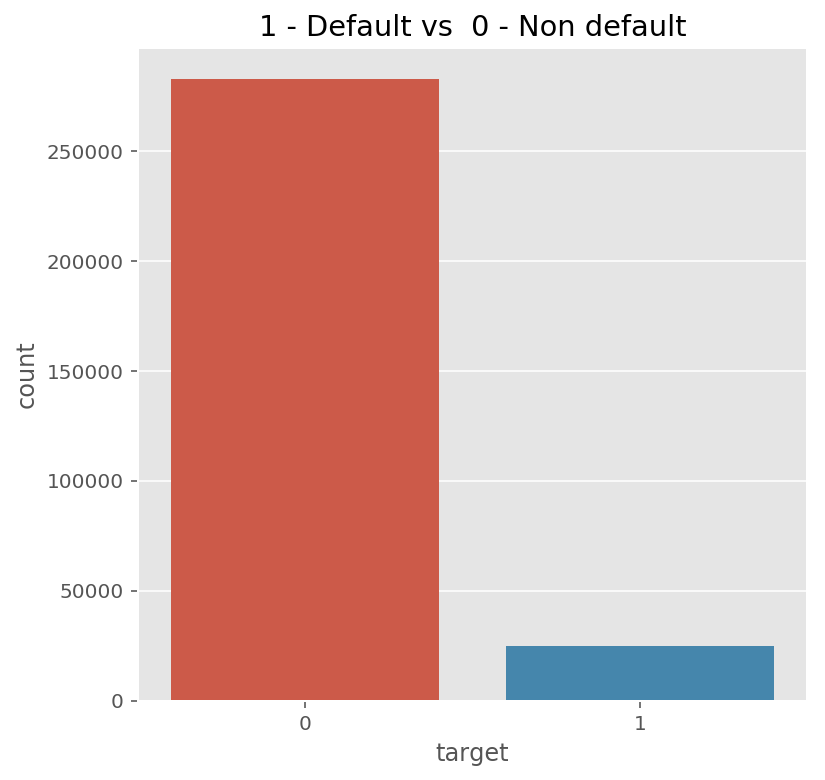

In [11]:
target = application_train["TARGET"].value_counts()
df = pd.DataFrame({'target': target.index,
                   'count': target.values
                  })
plt.figure(figsize = (6,6))
plt.title('1 - Default vs  0 - Non default')
sns.barplot(x = 'target', y="count", data=df);

We can see that the target is very imbalanced. There are far more loans repaid on time than loans that were not repaid on time. 

## Correlation

We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method. It does give us an idea of possible relationships within the data.

In [12]:
# Find correlations with the target and sort
correlations = application_train.corr()['TARGET'].sort_values()

In [13]:
nb = 4
corr_table = pd.DataFrame({'Most positive corr column':correlations.tail(nb).index,
                           'Most positive corr value':correlations.tail(nb).values,
                           'Most negative corr column': correlations.head(nb).index,
                           'Most negative corr value': correlations.head(nb).values})
corr_table

,Most negative corr column,Most negative corr value,Most positive corr column,Most positive corr value
0,EXT_SOURCE_3,-0.178919,REGION_RATING_CLIENT,0.058899
1,EXT_SOURCE_2,-0.160472,REGION_RATING_CLIENT_W_CITY,0.060893
2,EXT_SOURCE_1,-0.155317,DAYS_BIRTH,0.078239
3,DAYS_EMPLOYED,-0.044932,TARGET,1.000000


## Scatter Matrix

In [14]:
corr_series = pd.concat([corr_table['Most positive corr column'],
                         corr_table['Most negative corr column']], ignore_index=True)
corr_series

0           REGION_RATING_CLIENT
1    REGION_RATING_CLIENT_W_CITY
2                     DAYS_BIRTH
3                         TARGET
4                   EXT_SOURCE_3
5                   EXT_SOURCE_2
6                   EXT_SOURCE_1
7                  DAYS_EMPLOYED
dtype: object

Randomly sample 1000 rows to build the scatter matrix, otherwise too much data will make this process too slow and scatter plot unreadable.

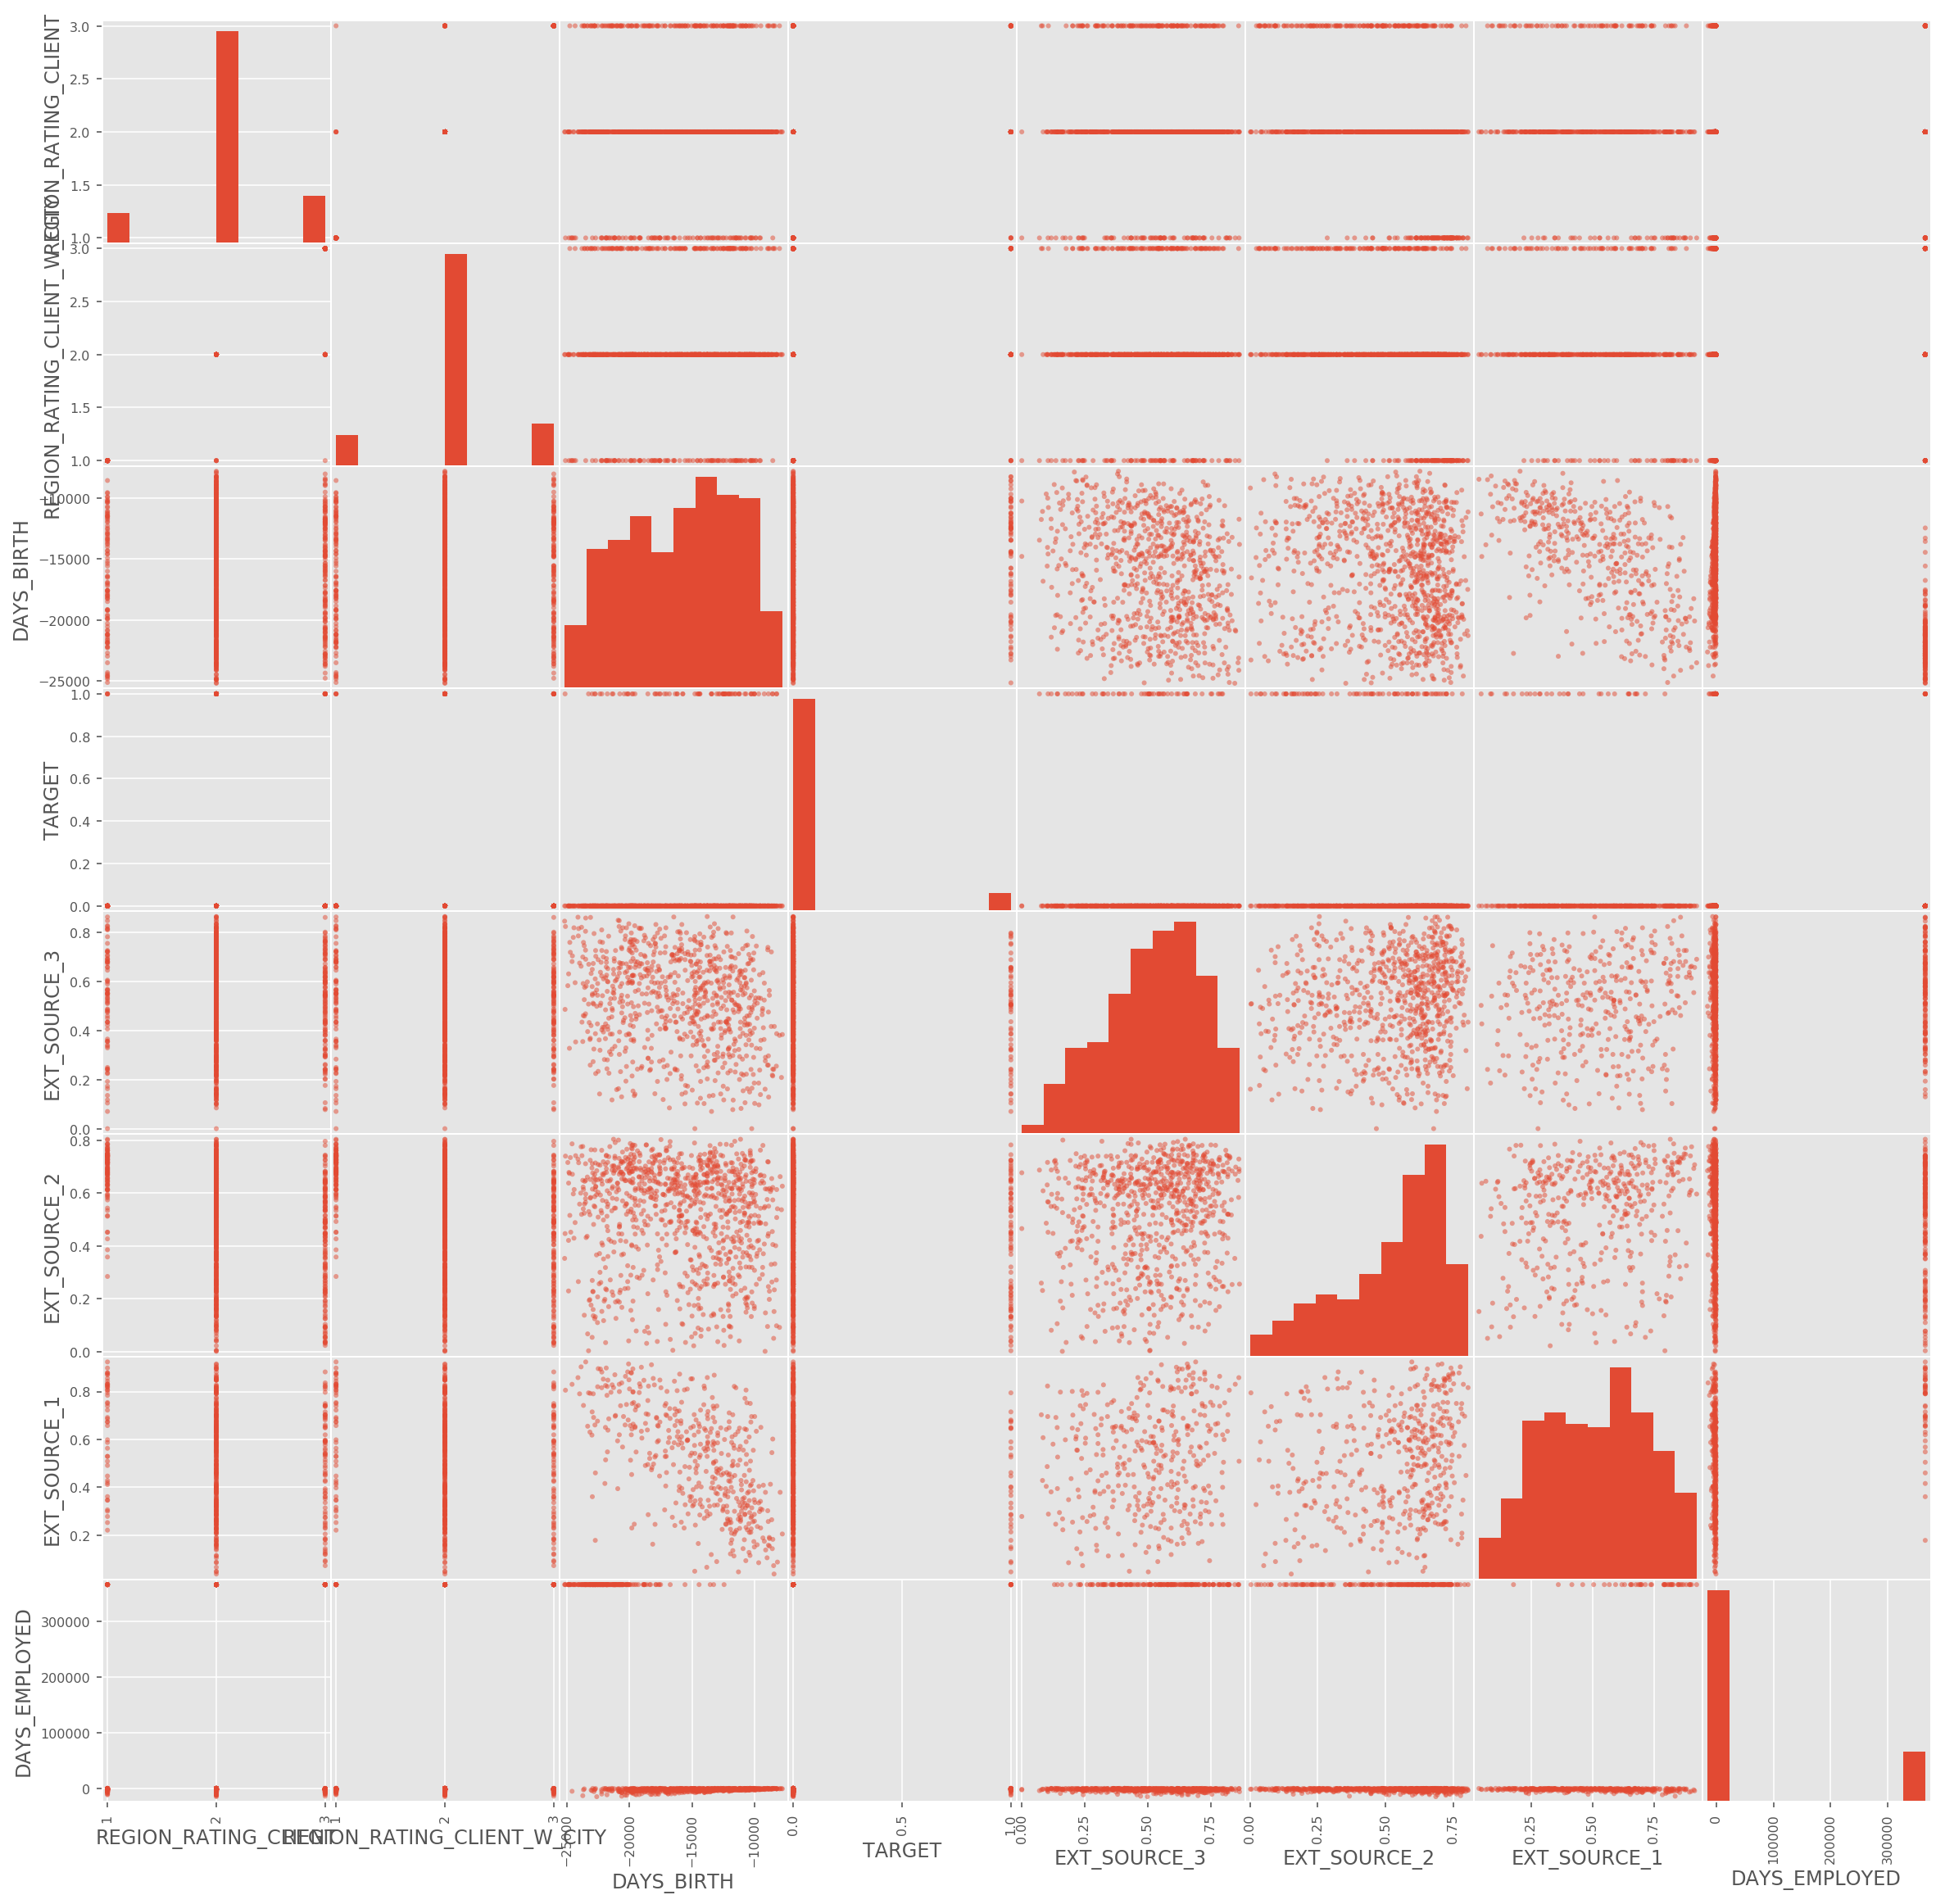

In [15]:
pd.plotting.scatter_matrix(application_train.sample(1000).loc[:,corr_series.values],
                           figsize=(20,20));

Using eyeballing method, we can see some interesting **interaction** between variable:

- TARGET AND DAYS_BIRTH
- TARGET AND EXT_SOURCE_1
- DAYS_BIRTH and EXT_SOURCE_1
- DAYS_BIRTH and DAYS_EMPLOYED
- EXT_SOURCE_2 or 1 AND REGION_RATING_CLIENT
- etc ... 

Later, let's focus on these features to analyse one by one.

Now, instead of using eyeball method, let's put a heatmap on the correlation of these features.

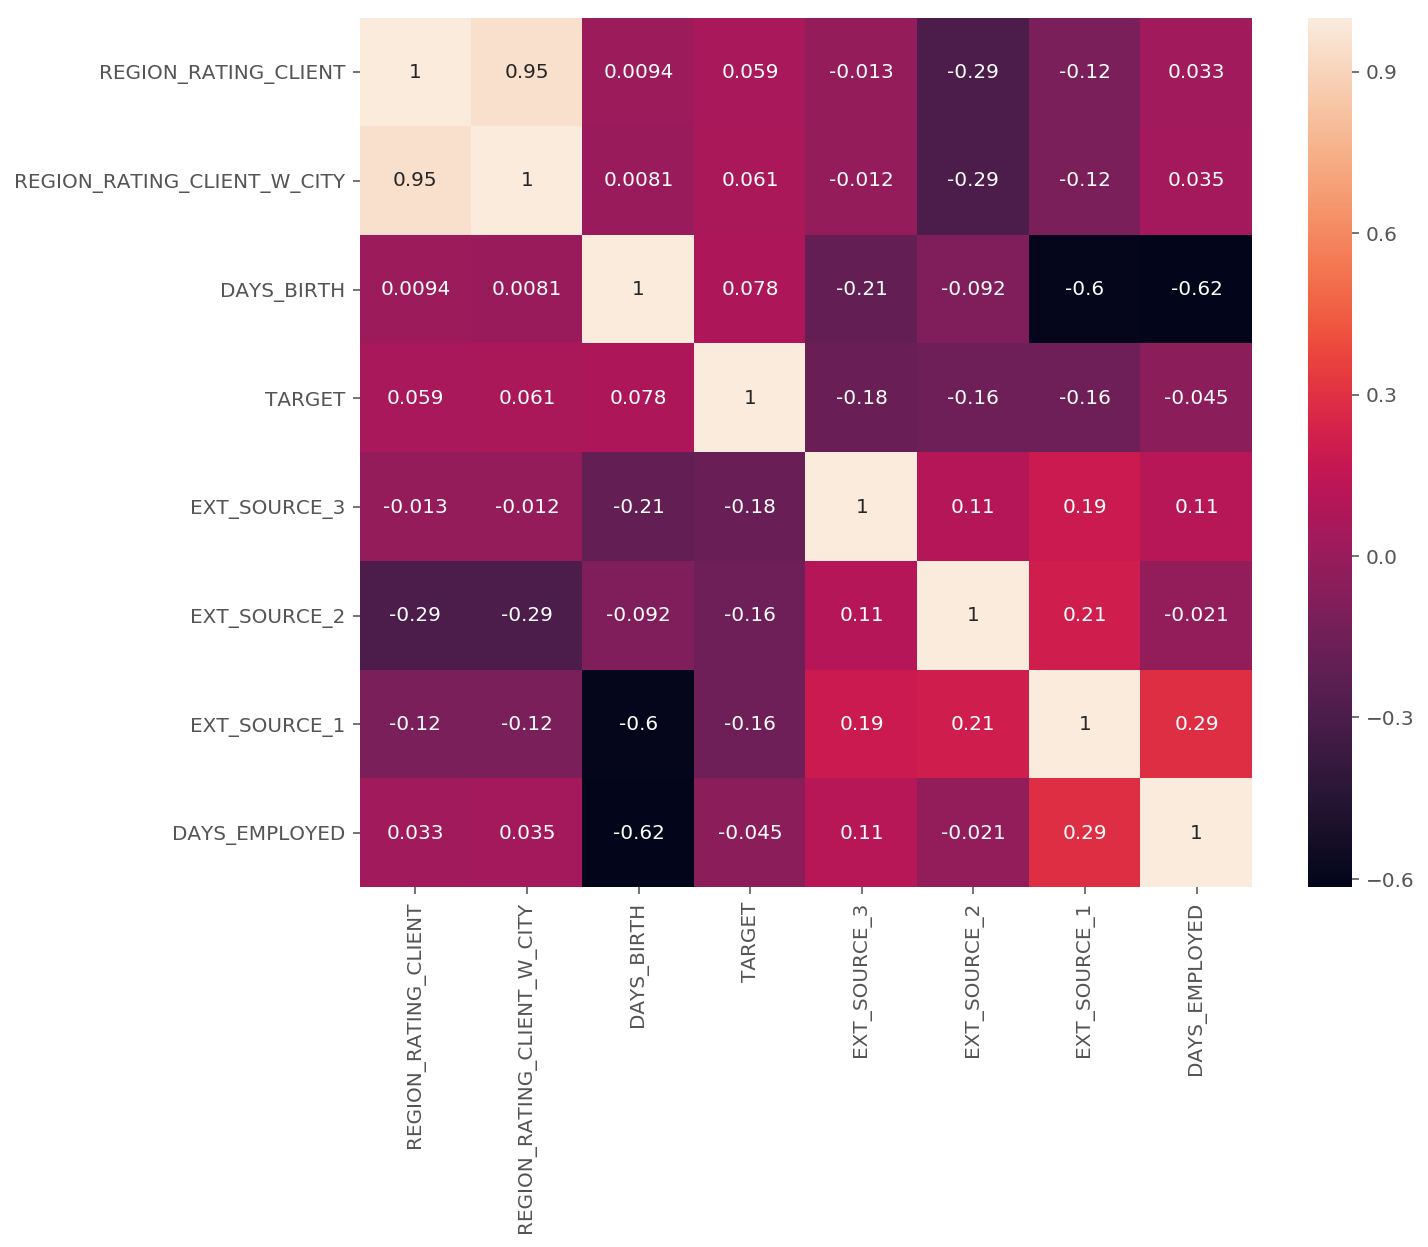

In [16]:
df_corr = application_train[corr_series].corr()
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, annot=True);

What you discover from heatmap?

## DAYS_BIRTH

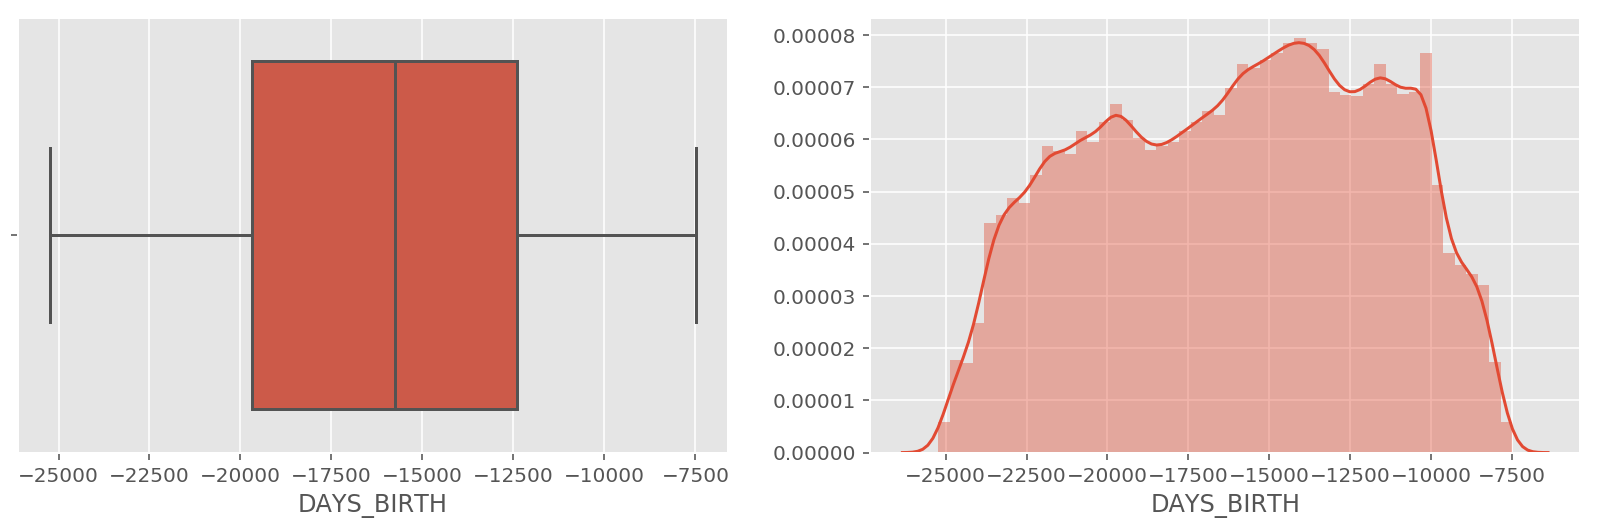

In [17]:
plot_data("DAYS_BIRTH", application_train)

In [18]:
col_name("DAYS_BIRTH")

DAYS_BIRTH: 

Client's age in days at the time of application

Table: ['application_{train|test}.csv']



- For some unknown reason, DAYS_BIRTH is recorded by days and in negative value.
- Need to transform them to normal birth date.

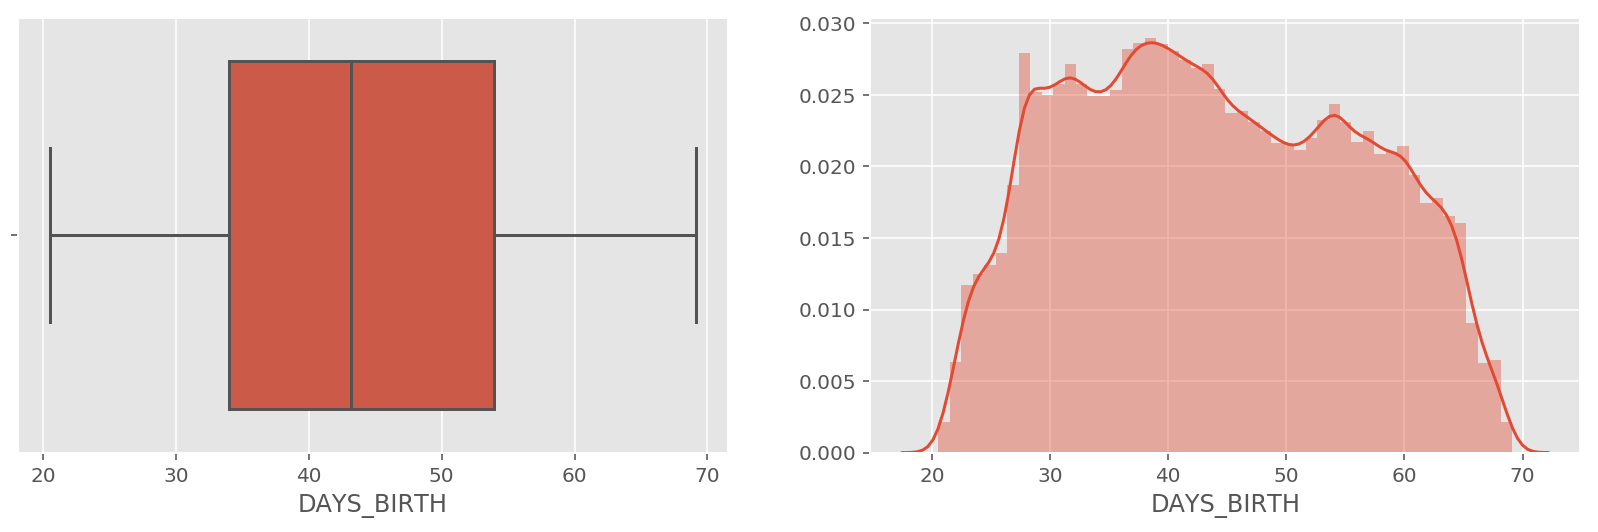

In [19]:
application_train["DAYS_BIRTH"] = application_train["DAYS_BIRTH"]/-365
plot_data("DAYS_BIRTH", application_train)

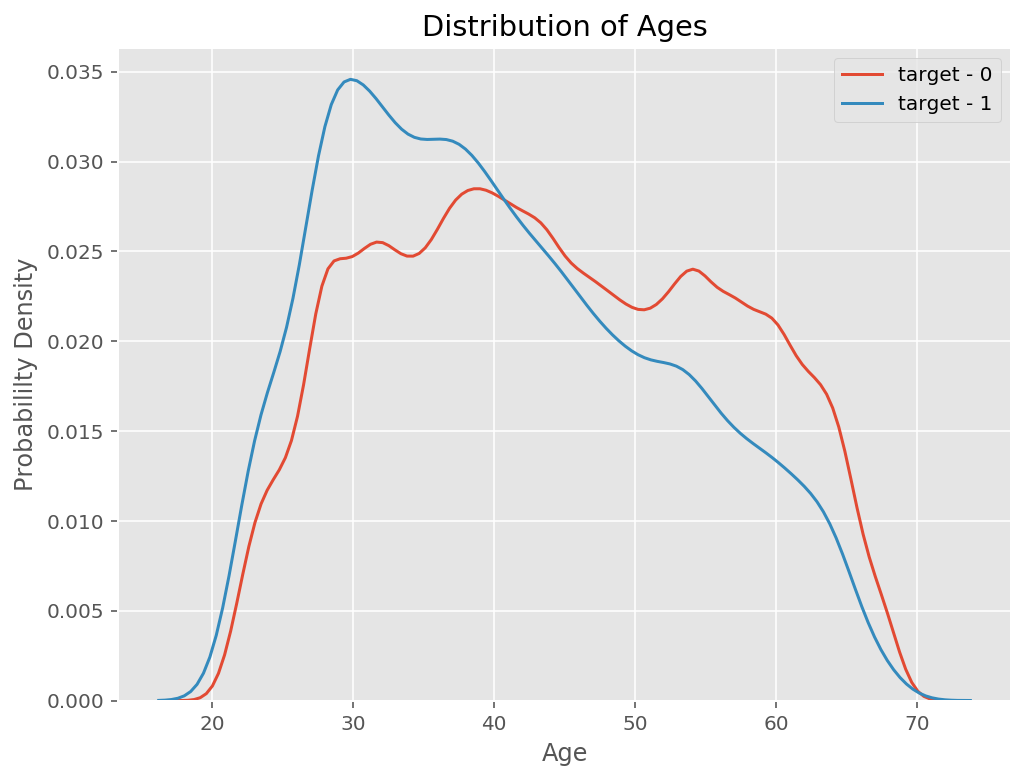

In [20]:
plt.figure(figsize = (8, 6))

sns.distplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'],
             label='target - 0', hist=False)
sns.distplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'],
             label = 'target - 1', hist=False)

plt.legend()
plt.xlabel('Age');
plt.ylabel('Probabililty Density');
plt.title('Distribution of Ages');

It seems the older we are getting, the less likely we default on loans.

### REGION_RATING_CLIENT_W_CITY

In [21]:
col_name("REGION_RATING_CLIENT_W_CITY")

REGION_RATING_CLIENT_W_CITY: 

Our rating of the region where client lives with taking city into account (1,2,3)

Table: ['application_{train|test}.csv']



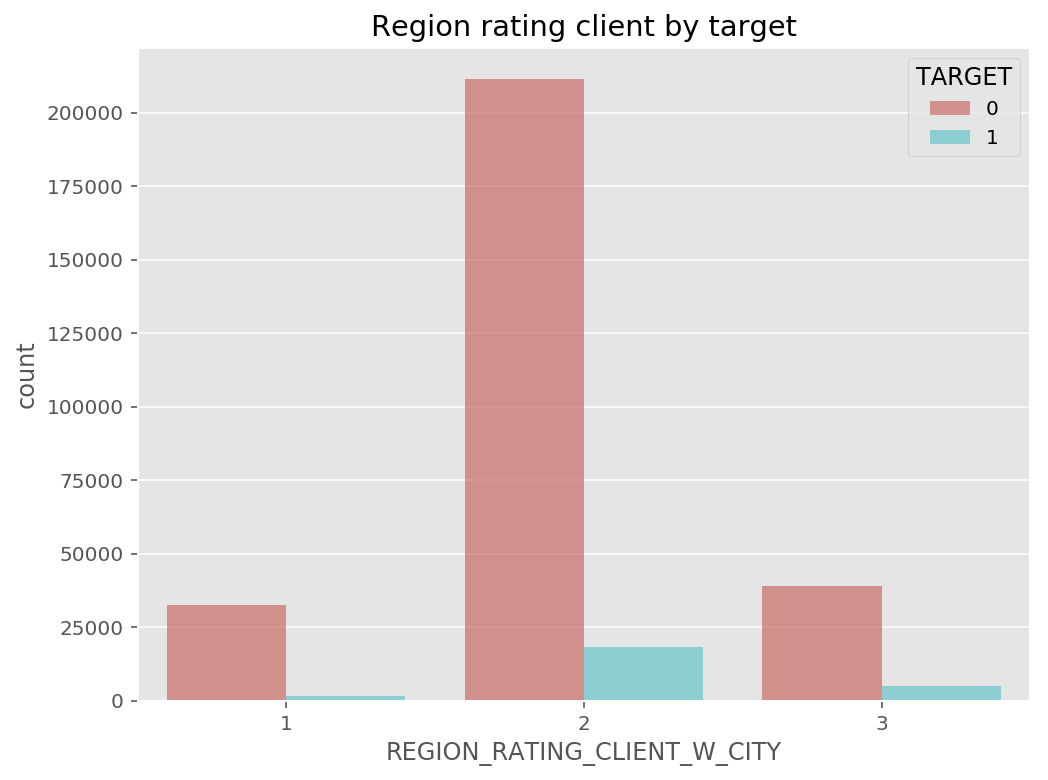

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(x="REGION_RATING_CLIENT_W_CITY",
              hue="TARGET", data=application_train, order=[1,2,3], alpha=0.7, palette="hls")
plt.title('Region rating client by target');

I suspect that the proportion of default won't be the same for each categories.

In [23]:
temp = application_train.groupby(['REGION_RATING_CLIENT_W_CITY','TARGET']).apply(
    lambda rows: len(rows)).unstack()
temp['pct_0']=temp.loc[:,0]/temp.loc[:,0].sum()
temp['pct_1']=temp.loc[:,1]/temp.loc[:,1].sum()
temp

TARGET,0,1,pct_0,pct_1
REGION_RATING_CLIENT_W_CITY,,,,
1,32513,1654,0.115015,0.066626
2,211314,18170,0.747522,0.731923
3,38859,5001,0.137463,0.201450


Percentage differece is more obvious between rating 1 and 3.

Since REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT are highly correlated(0.95), the latter could be redundant for our classifier model, so let's just skip this one for now.

## EXT_SOURCE_3

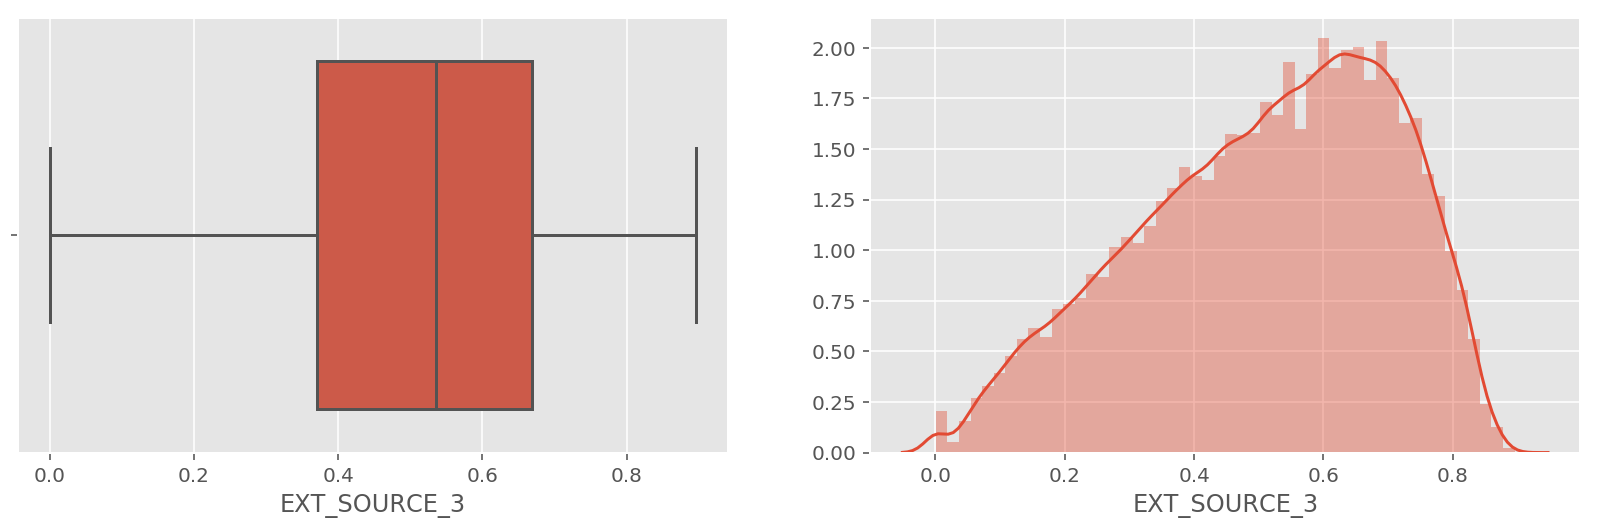

In [24]:
plot_data("EXT_SOURCE_3", application_train)

Looks promising, even though we don't know what it really means.

```EXT_SOURCE_2: 

Normalized score from external data source

Table: ['application_{train|test}.csv']

Missing values:
Total      660.000000
Percent      0.214626
Name: EXT_SOURCE_2, dtype: float64

count    3.068510e+05
mean     5.143927e-01
std      1.910602e-01
min      8.173617e-08
25%      3.924574e-01
50%      5.659614e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64```

About 20% of its data are missing.

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


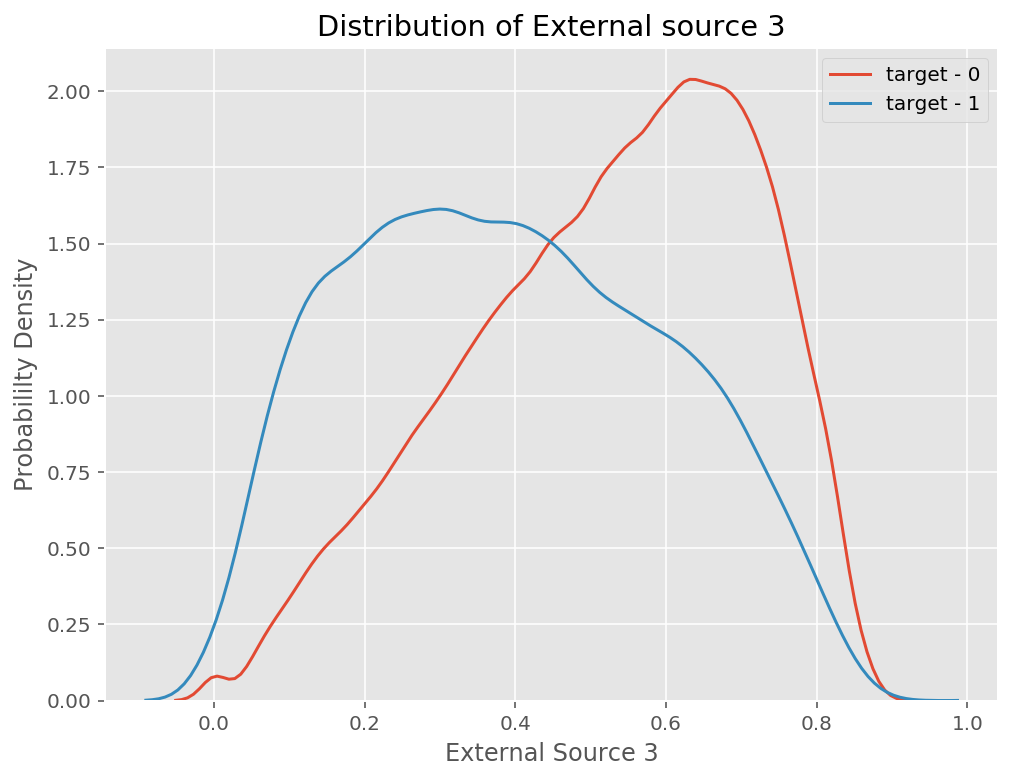

In [25]:
plt.figure(figsize = (8, 6))

sns.distplot(application_train.loc[application_train['TARGET'] == 0, 'EXT_SOURCE_3'],
             label='target - 0', hist=False)
sns.distplot(application_train.loc[application_train['TARGET'] == 1, 'EXT_SOURCE_3'],
             label = 'target - 1', hist=False)

plt.legend()
plt.xlabel('External Source 3')
plt.ylabel('Probabililty Density')
plt.title('Distribution of External source 3');

Very interesting!

## EXT_SOURCE_2

```
EXT_SOURCE_2: 

Normalized score from external data source

Table: ['application_{train|test}.csv']

Missing values:
Total      660.000000
Percent      0.214626
Name: EXT_SOURCE_2, dtype: float64

count    3.068510e+05
mean     5.143927e-01
std      1.910602e-01
min      8.173617e-08
25%      3.924574e-01
50%      5.659614e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64
```

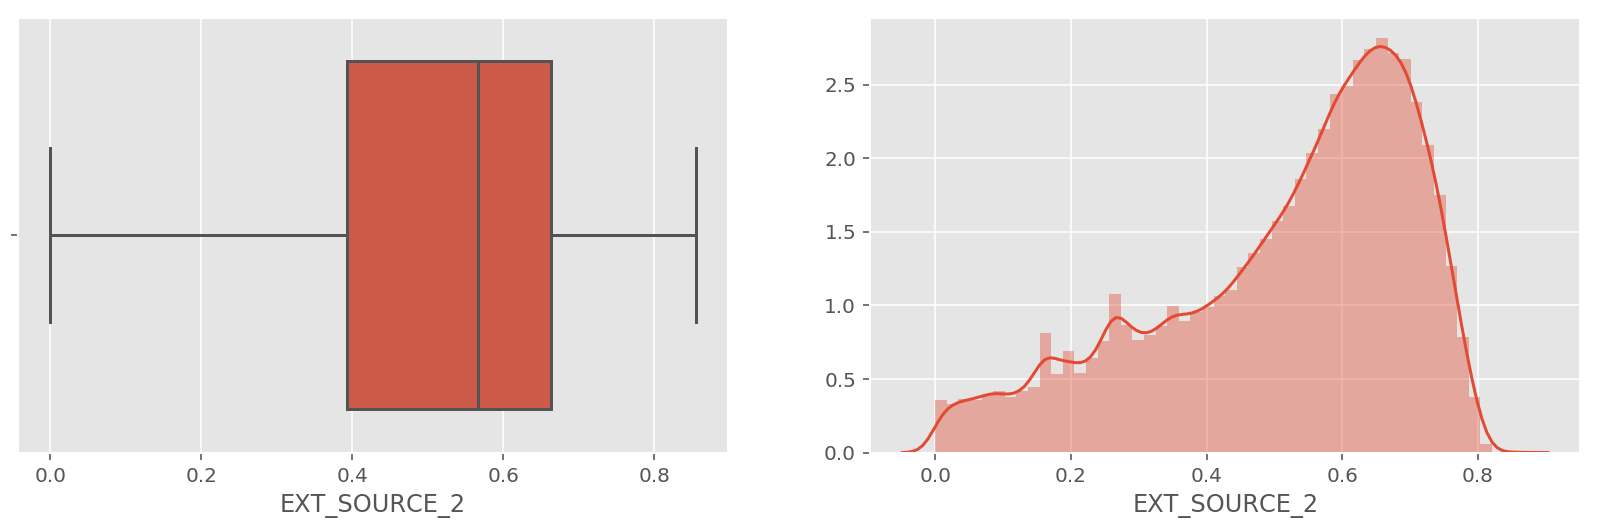

In [26]:
plot_data("EXT_SOURCE_2", application_train)

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


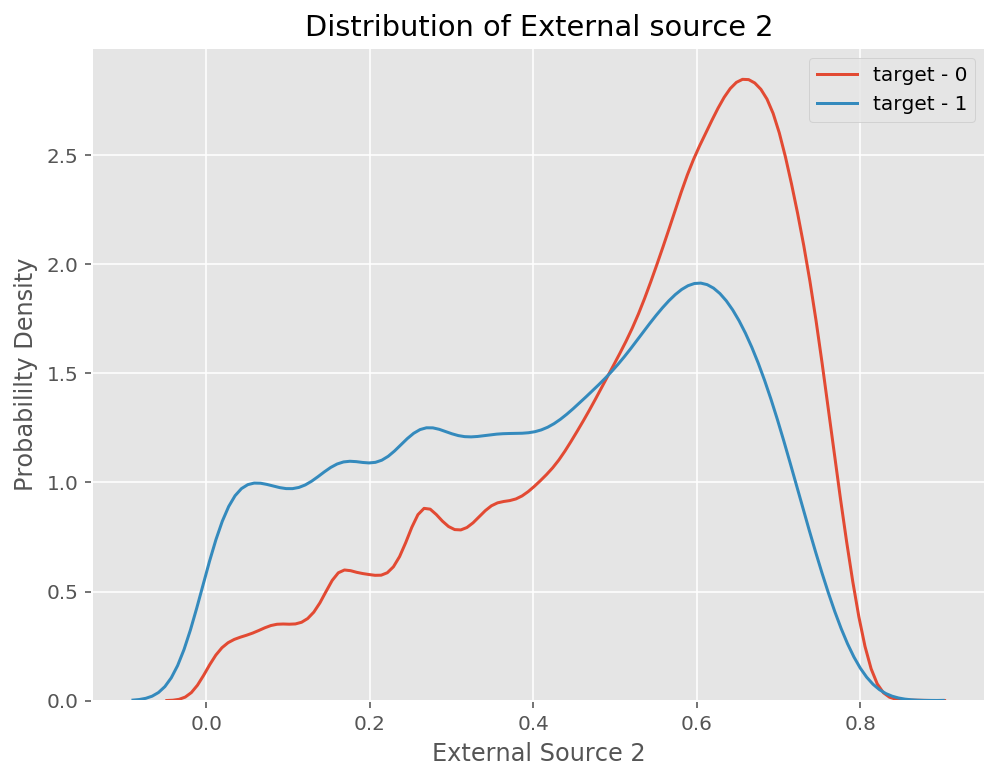

In [27]:
plt.figure(figsize = (8, 6))

sns.distplot(application_train.loc[application_train['TARGET'] == 0, 'EXT_SOURCE_2'],
             label='target - 0', hist=False)
sns.distplot(application_train.loc[application_train['TARGET'] == 1, 'EXT_SOURCE_2'],
             label = 'target - 1', hist=False)

plt.legend()
plt.xlabel('External Source 2')
plt.ylabel('Probabililty Density')
plt.title('Distribution of External source 2');

- Most default case has lower source 2 score than default case, the latter has a fatter tail.

## EXT_SOURCE_1

```
Normalized score from external data source

Table: ['application_{train|test}.csv']

Missing values:
Total      173378.000000
Percent        56.381073
Name: EXT_SOURCE_1, dtype: float64

count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64
```

56% data are missing...

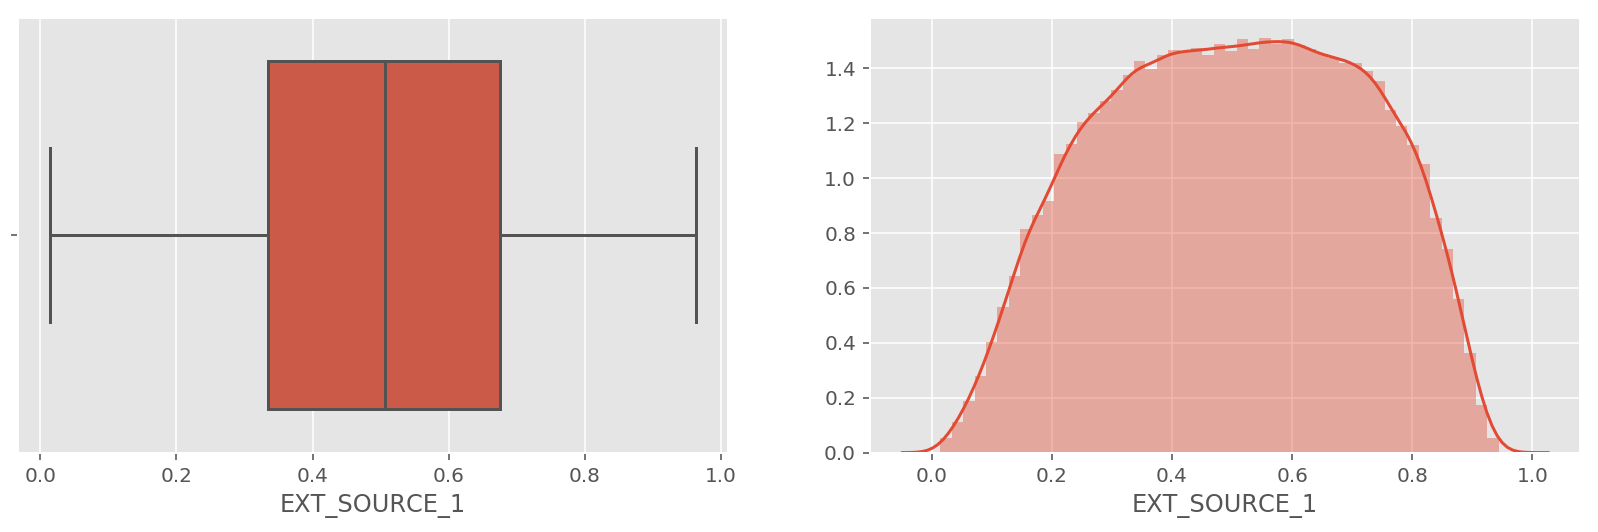

In [28]:
plot_data("EXT_SOURCE_1", application_train)

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


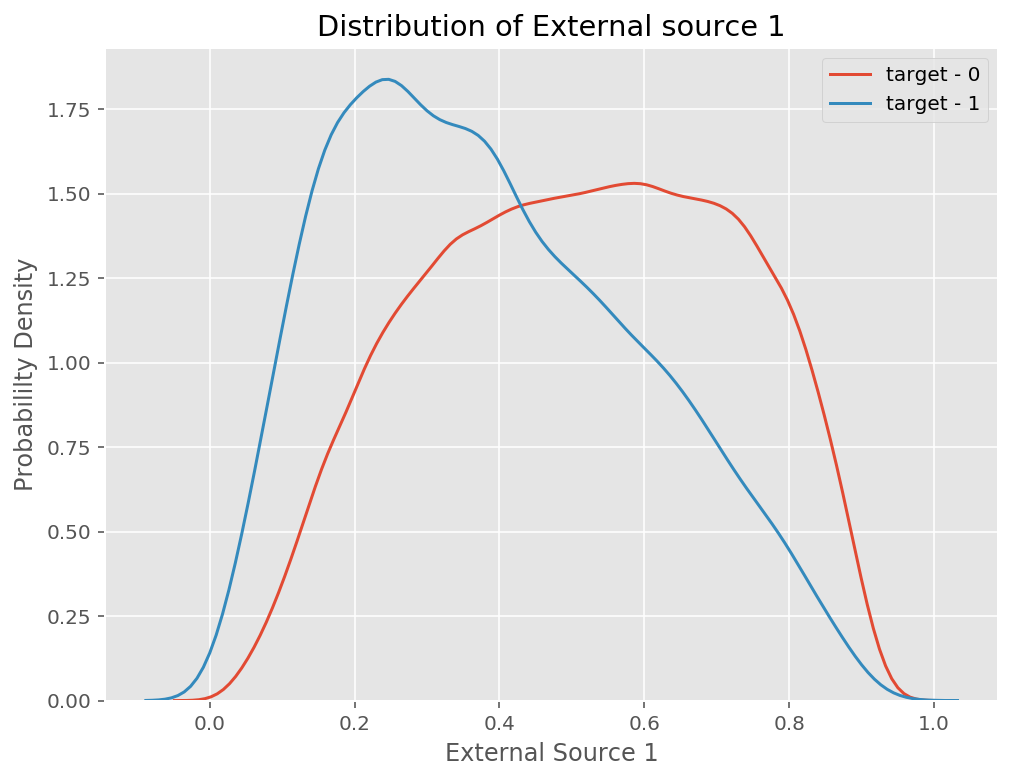

In [29]:
plt.figure(figsize = (8, 6))

sns.distplot(application_train.loc[application_train['TARGET'] == 0, 'EXT_SOURCE_1'],
             label='target - 0', hist=False)
sns.distplot(application_train.loc[application_train['TARGET'] == 1, 'EXT_SOURCE_1'],
             label = 'target - 1', hist=False)

plt.legend()
plt.xlabel('External Source 1')
plt.ylabel('Probabililty Density')
plt.title('Distribution of External source 1');

- Default cases looks like more concentrated around 0.1-0.5.

# DAYS_EMPLOYED

```
DAYS_EMPLOYED: 

How many days before the application the person started current employment

Table: ['application_{train|test}.csv']

Missing values:
Total      0.0
Percent    0.0
Name: DAYS_EMPLOYED, dtype: float64

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64
```

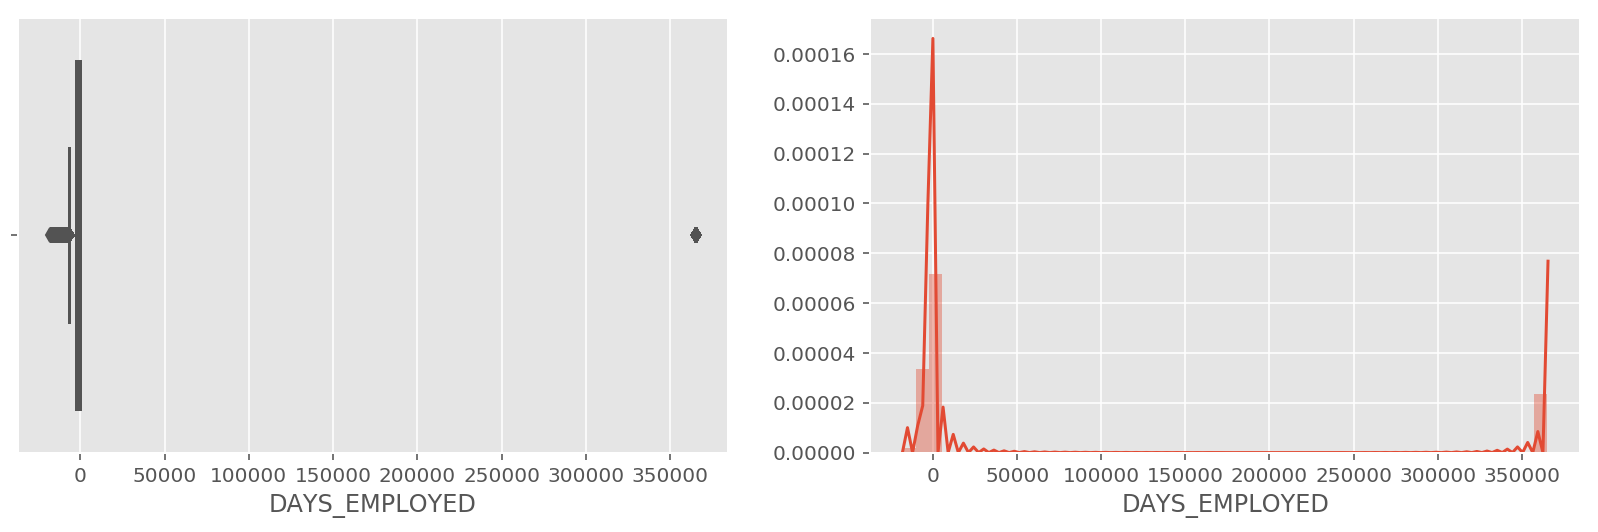

In [30]:
plot_data("DAYS_EMPLOYED", application_train)

Let's check these outliers first.

In [31]:
application_train["DAYS_EMPLOYED"].value_counts()[:10]

 365243    55374
-200         156
-224         152
-199         151
-230         151
-212         150
-229         143
-384         143
-231         140
-215         138
Name: DAYS_EMPLOYED, dtype: int64

In [32]:
application_train[application_train["DAYS_EMPLOYED"]>0]["SK_ID_CURR"].count()

55374

Most values are negative, but there are 55374 rows having the same value: 365243.

I am not sure what that means...
Let's separate them into 2 categories and see if the sign can have some impact on the target.

In [33]:
neg_days_employed = application_train[application_train["DAYS_EMPLOYED"]<=0]
pos_days_employed = application_train[application_train["DAYS_EMPLOYED"]>0]

In [34]:
print(pos_days_employed.TARGET.value_counts(1))
print('\n')
print(neg_days_employed.TARGET.value_counts(1))

0    0.946004
1    0.053996
Name: TARGET, dtype: float64


0    0.9134
1    0.0866
Name: TARGET, dtype: float64


It seems that when the day employed is 365243, whatever this number is, it is more likely to be a non-default case than a default case.

However, this proportional difference looks pretty small, I doubt if they are statistically different? 

Let's review our **a/b testing**.

In [35]:
print(scs.ttest_ind(pos_days_employed.TARGET, neg_days_employed.TARGET, equal_var=False))

Ttest_indResult(statistic=-29.323497547200667, pvalue=3.477030937526138e-188)


Actually there is a satistically difference between 2 samples porpostion regarding the default rate.

Let's plot the data.

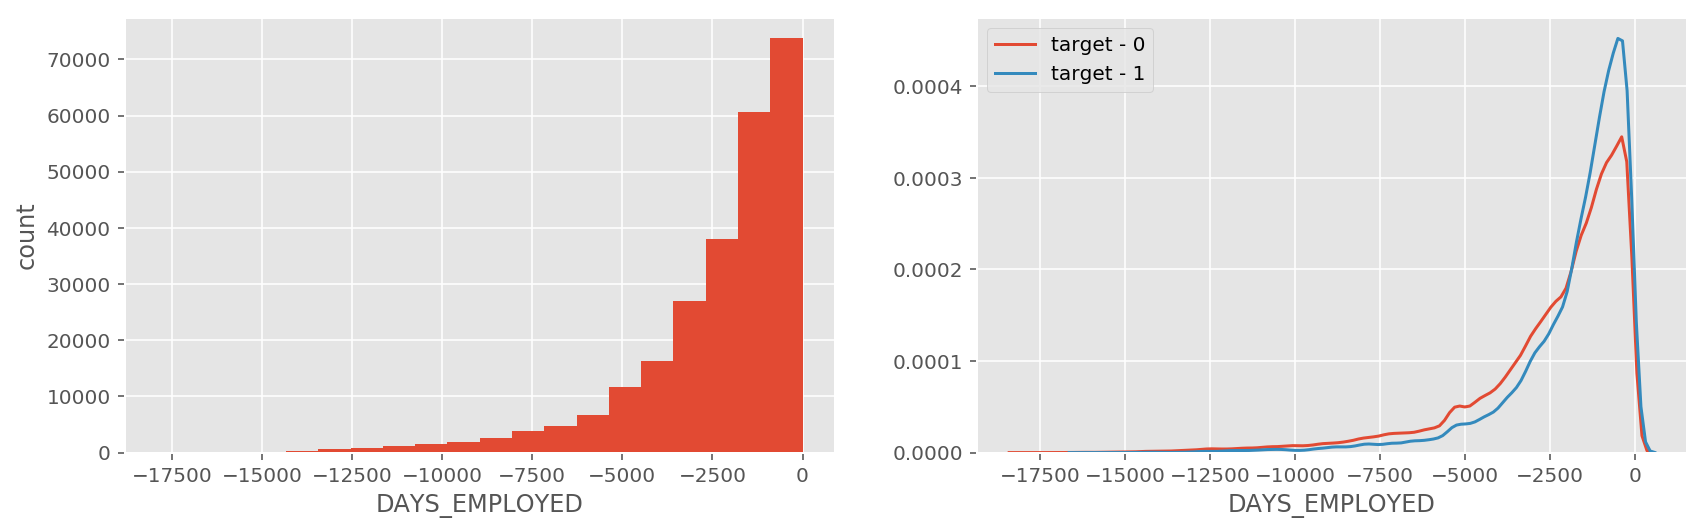

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

neg_days_employed.DAYS_EMPLOYED.hist(bins=20, ax=ax1)

sns.distplot(neg_days_employed.loc[neg_days_employed['TARGET'] == 0, 'DAYS_EMPLOYED'],
             label='target - 0', hist=False, ax=ax2)
sns.distplot(neg_days_employed.loc[neg_days_employed['TARGET'] == 1, 'DAYS_EMPLOYED'],
             label = 'target - 1', hist=False, ax=ax2);


ax1.set_xlabel('DAYS_EMPLOYED')
ax1.set_ylabel('count');


Excluding all positive number, default case happens more likely when employed days are short (from -1000 to 0).

Conclusion: there are some signals coming from DAYS_EMPLOYED features no matter their sign. So let's keep this feature in our model.

## Interaction

### EXT_SOURCE_1 &  DAYS_BIRTH
numeric vs numeric feature

Since the target is highly imbalanced, some facts might be hidden by such imbalance. I try to rebalance the weight of target 0 and 1 by simpling from our application_train. 

In [37]:
application = application_train.copy() # Keep the application as it is
application.dropna(inplace=True)
application_0 = application[application["TARGET"]==0]
application_1 = application[application["TARGET"]==1]

In [38]:
# sampling 500 each so I get 1000 rows in total with equal weight of target.
sample_1_reduced = application_1.sample(500)
sample_0_reduced = application_0.sample(500)
df_sampling = pd.concat([sample_1_reduced, sample_0_reduced], axis=0)

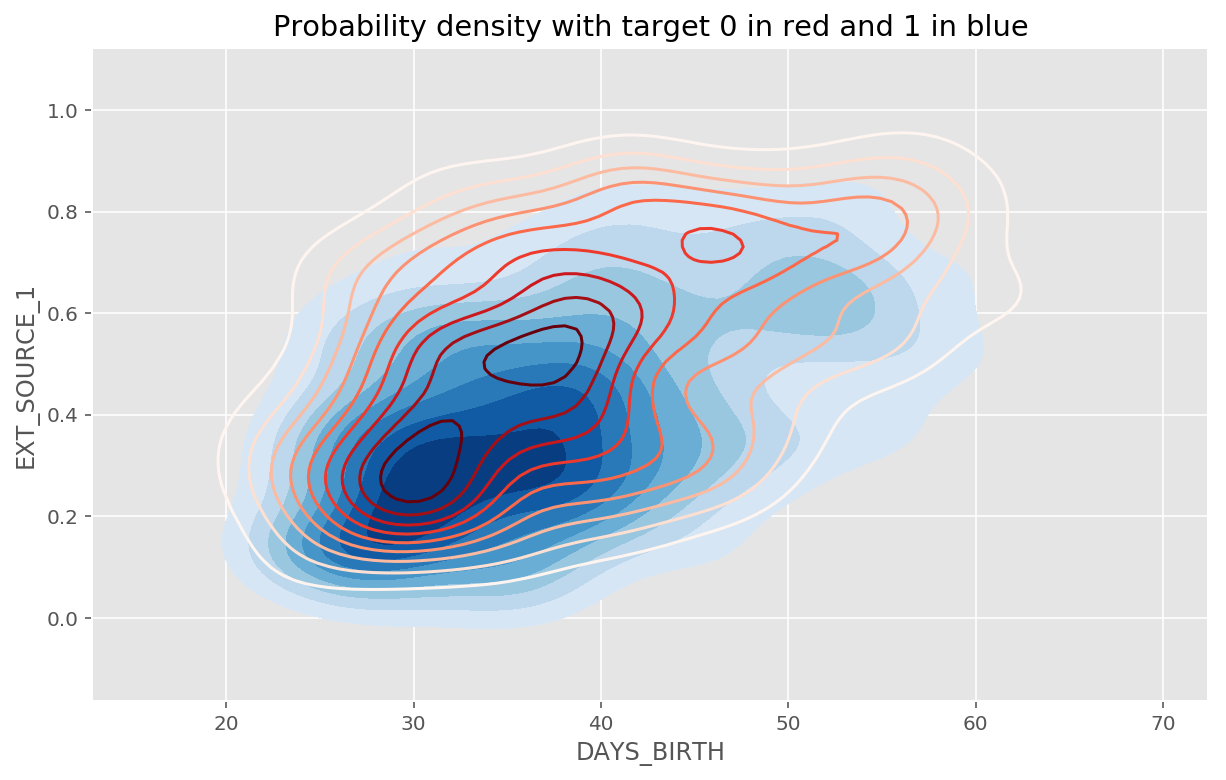

In [39]:
plt.figure(figsize=(10,6))

sns.kdeplot(sample_0_reduced.DAYS_BIRTH,
            sample_0_reduced.EXT_SOURCE_1, cmap="Reds", shade=False)
sns.kdeplot(sample_1_reduced.DAYS_BIRTH, sample_1_reduced.EXT_SOURCE_1,
            cmap="Blues",shade=True, shade_lowest=False)
plt.title('Probability density with target 0 in red and 1 in blue');
# I don't know how to make the legend work...

- Correlation between EXT_SOURCE_1 and DAYS_BIRTH
- Distribution density difference between target 0 and target 1

### EXT_SOURCE_1 & REGION_RATING_CLIENT_W_CITY
numeric vs categorical feature

In [40]:
sample_1_reduced = application_1.sample(50)
sample_0_reduced = application_0.sample(50)
df_sampling = pd.concat([sample_1_reduced, sample_0_reduced], axis=0)

To make the scatter plot more readable, (too many dots could lay over each other), I only sample 50 from each target label.

In [41]:
df_sampling.shape

(100, 122)

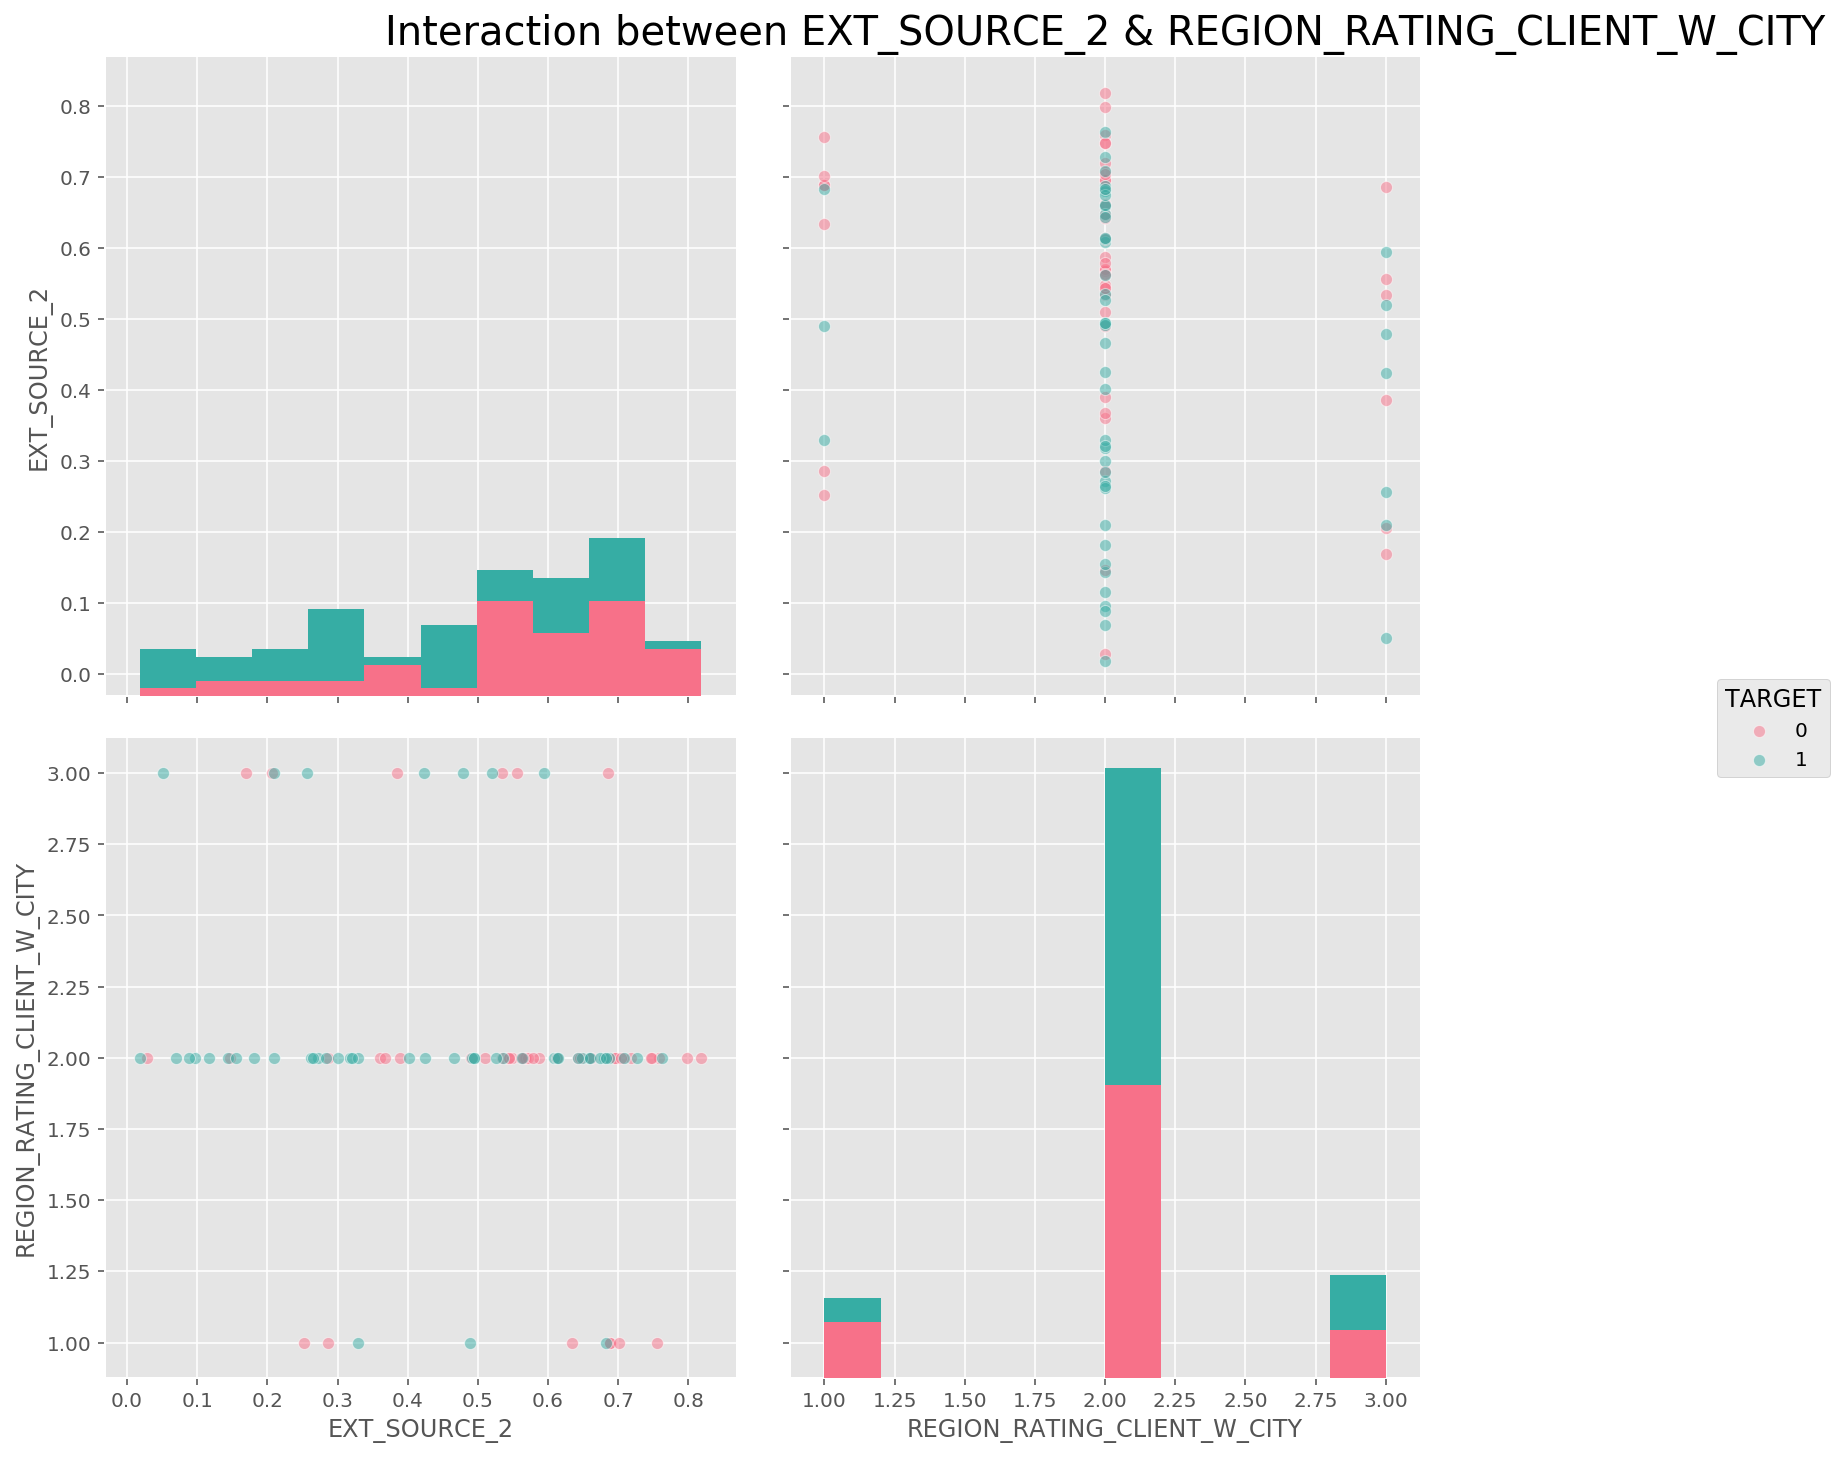

In [42]:
sns.pairplot(df_sampling, hue='TARGET',
             vars=['EXT_SOURCE_2','REGION_RATING_CLIENT_W_CITY'],
                       size=5, palette="husl", plot_kws={'alpha':0.5});
plt.title('Interaction between EXT_SOURCE_2 & REGION_RATING_CLIENT_W_CITY',
          {'fontsize': 20});

Copie from previous table:
```
TARGET   pct_0	   pct_1
REGION_RATING_CLIENT_W_CITY				
1		0.115015	0.066626
2		0.747522	0.731923
3		0.137463	0.201450
```

Botton Left:

- region rating 1 and high score 2 (0.6-0.8) --> very like non default
- region ration 2 and 3 and low score (0-0.3) --> very like default

# Logistic regression model

Let's feed our logit regression model with all the features we just looked including interaction effet.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_curve
from sklearn.preprocessing import PolynomialFeatures, Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

In [44]:
df_train_1 = application_train[['TARGET','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY',
                              'DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
# df_train_1['REGION_RATING_CLIENT_W_CITY'] = pd.get_dummies(df_train_1['REGION_RATING_CLIENT_W_CITY'],
#                                                            drop_first=True)
# Binarizing performs worse.

In [45]:
df_train_1.head()

,TARGET,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,25.920548,2,-637,0.083037,0.262949,0.139376
1,0,45.931507,1,-1188,0.311267,0.622246,NaN
2,0,52.180822,2,-225,NaN,0.555912,0.729567
3,0,52.068493,2,-3039,NaN,0.650442,NaN
4,0,54.608219,2,-3038,NaN,0.322738,NaN


- Dealing with all nan by imputer their median
- Rescalling all the features

In [56]:
X = df_train_1.drop('TARGET',axis=1).values
y = df_train_1['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

# imputer all the nan by median or mean
imp = Imputer(strategy='median') 
imp.fit(X_train)

# transform the test & train data
X_train=imp.transform(X_train)
X_test=imp.transform(X_test)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (230633, 6)
Testing data shape:  (76878, 6)


## Cross Validation & ROC curve

To give some consistant results of all the metrics --> Cross validation

In [57]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

accuracies = []
precisions = []
recalls = []
aucs = []

for train_index, test_index in kf.split(X_train):
    model = LogisticRegression()
    model.fit(X_train[train_index], y_train[train_index])
#     proba = model.predict_proba(X_train[test_index])[:, 1]
#     y_predict = proba>=0.15
    
    y_predict = model.predict(X_train[test_index])
    y_true = y_train[test_index]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict)
    
    
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))
    aucs.append(auc(fpr, tpr))
    
    
print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))
print("auc:", np.average(aucs))

accuracy: 0.919772972373
precision: 0.437191073562
recall: 0.00351398721525
auc: 0.501566096677


### AUC under test set

0.718859674943


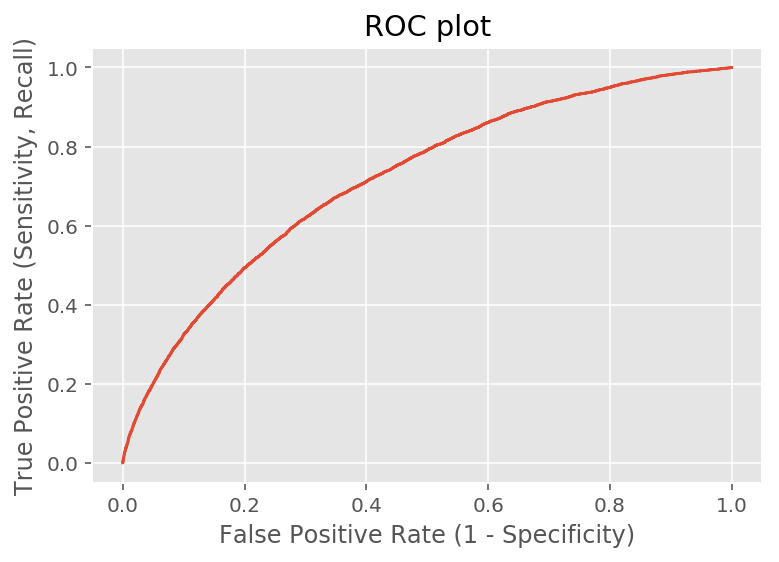

In [58]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot")
plt.show()

## Feature Engineering

Try some interaction terms between features by multiplying/dividing each others.

In [59]:
df_train_2 = application_train[['TARGET','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY',
                              'DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

df_train_2['Days_vs_source_1'] = df_train_2['DAYS_BIRTH']/df_train_2['DAYS_BIRTH']
df_train_2['Days_vs_employed'] = df_train_2['DAYS_EMPLOYED']/df_train_2['DAYS_BIRTH']
df_train_2['EXT_SOURCE_2_vs_REGION_RATING_CLIENT_W_CITY'] = df_train_2['EXT_SOURCE_2']*df_train_2['REGION_RATING_CLIENT_W_CITY']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [60]:
X = df_train_2.drop('TARGET',axis=1).values
y = df_train_2['TARGET'].values


X_train, X_test, y_train, y_test = train_test_split(X, y)

# imputer all the nan by median or mean
imp = Imputer(strategy='median') 
imp.fit(X_train) 

# transform the test & train data
X_train=imp.transform(X_train)
X_test=imp.transform(X_test)

# rescaling features is important
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (230633, 9)
Testing data shape:  (76878, 9)


In [61]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

accuracies = []
precisions = []
recalls = []
aucs = []

for train_index, test_index in kf.split(X_train):
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train[train_index], y_train[train_index])
    
#     proba = model.predict_proba(X_train[test_index])[:, 1]
#     y_predict = proba>=0.15   
#     changing the thresholds can change the tpr and fpr
    
    y_predict = model.predict(X_train[test_index])
    y_true = y_train[test_index]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict)
    
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))
    aucs.append(auc(fpr, tpr))
    
    
print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))
print("auc:", np.average(aucs))

accuracy: 0.675337000118
precision: 0.150016737718
recall: 0.646215394613
auc: 0.662058650965


The recall rate become suddenly much higher with this model at cost of precision. I wonder why?
```
1st model:
accuracy: 0.919772972373
precision: 0.437191073562
recall: 0.00351398721525
auc: 0.501566096677
```


0.720336931064


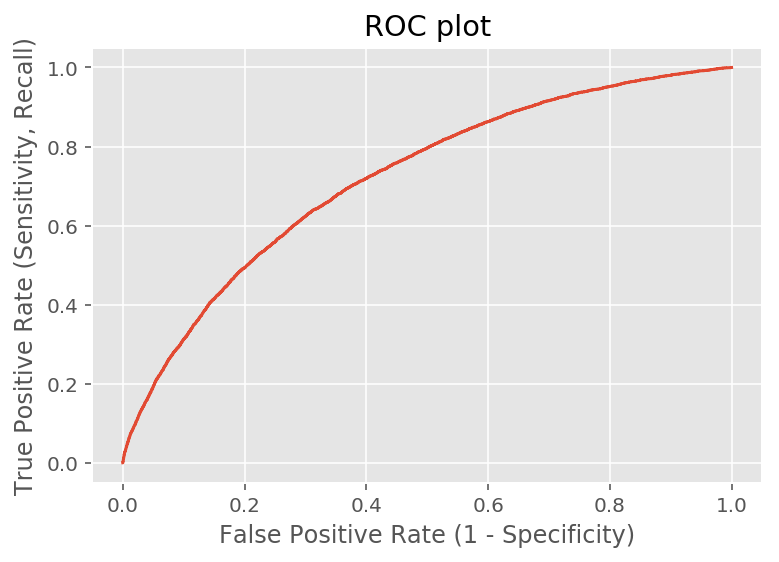

In [62]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot")
plt.show()

AUC gets slightly better.

## Submission

In [63]:
application_train = pd.read_csv('data/application_train.csv.zip') 
application_test = pd.read_csv('data/application_test.csv.zip') 

Last step, retrain model with all the data.

In [64]:
df_train = application_train[['TARGET','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY',
                              'DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

df_train["DAYS_BIRTH"] = df_train["DAYS_BIRTH"]/-365
df_train['Days_vs_source_1'] = df_train['DAYS_BIRTH']/df_train['DAYS_BIRTH']
df_train['Days_vs_employed'] = df_train['DAYS_EMPLOYED']/df_train['DAYS_BIRTH']
df_train['EXT_SOURCE_2_vs_REGION_RATING_CLIENT_W_CITY'] = df_train['EXT_SOURCE_2']*df_train['REGION_RATING_CLIENT_W_CITY']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [65]:
df_test = application_test[['DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY',
                              'DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]

df_test["DAYS_BIRTH"] = df_test["DAYS_BIRTH"]/-365
df_test['Days_vs_source_1'] = df_test['DAYS_BIRTH']/df_test['DAYS_BIRTH']
df_test['Days_vs_employed'] = df_test['DAYS_EMPLOYED']/df_test['DAYS_BIRTH']
df_test['EXT_SOURCE_2_vs_REGION_RATING_CLIENT_W_CITY'] = df_test['EXT_SOURCE_2']*df_test['REGION_RATING_CLIENT_W_CITY']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [66]:
X_train = df_train.drop('TARGET',axis=1).values
y_train = df_train['TARGET'].values

In [67]:
X_test = df_test.values

In [68]:
imp = Imputer(strategy='median') 
imp.fit(X_train) 

# transform the test & train data
X_train=imp.transform(X_train)
X_test=imp.transform(X_test)


scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (307511, 9)
Testing data shape:  (48744, 9)


In [69]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

In [70]:
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = probabilities
submit.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.407144
1,100005,0.604182
2,100013,0.280940
3,100028,0.377532
4,100038,0.617459


In [71]:
submit.to_csv('logistic_baseline.csv', index = False)

AUC feedback from Kaggle --> 0.711

Since we only used 6 feautures(among 121 features) from just the main table, the result is not so bad.

THIS IS THE BASELINE MODEL. THIS WEEK'S JOB IS TO BEAT IT USING LOGISTIC REGRESSION.
IN THE FUTURE WE CAN TRY TREE BASED MODELS OR DEEP LEARNING MODELS TO GET A MUCH HIGHER SCORE.


What we can possibly do next:
- write some function/class to make feature engineering easier
- examine more features correlated to target or picking features using domain knowledge
- feature engineering using all kind of creativity...
- implement a pipeline including imputation/rescaling/cv (hyperparameters c) etc. (google sklearn pipeline)
- could try forward/backward search method for feature selection

Any ideas help to improve the performance of model is welcome and worth trying, submit and share your secrets with us.